In [1]:
%matplotlib inline

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

from weavingspace.symmetry import Symmetries
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

### Some test polygons

In [2]:
polys = [
  tiling_utils.get_regular_polygon(1000, n = 4),
  tiling_utils.get_regular_polygon(1000, n = 5),
  TileUnit(tiling_type = "hex-dissection", n = 12).tiles.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 6).tiles.geometry[1],
  TileUnit(tiling_type = "hex-dissection", n = 4).tiles.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 3).tiles.geometry[0],
  affine.scale(tiling_utils.get_regular_polygon(1000, n = 3), 0.8, 0.9),
  TileUnit(tiling_type = "cairo", n = 3).tiles.geometry[0],
  TileUnit(tiling_type = "archimedean", code = "4.8.8").tiles.geometry[1]]

# translate to centroid (this is to make drawing easier, not required)
polys = [affine.translate(p, -p.centroid.x, -p.centroid.y) for p in polys]

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


### Find symmetries

In [3]:
symmetries = [Symmetries(p) for p in polys]
symmetries[0].rotations, symmetries[0].reflection_axes

([0.0, 90.0, 180.0, 270.0], [45.0, 0.0, -45.0, -90.0])

### Plot them

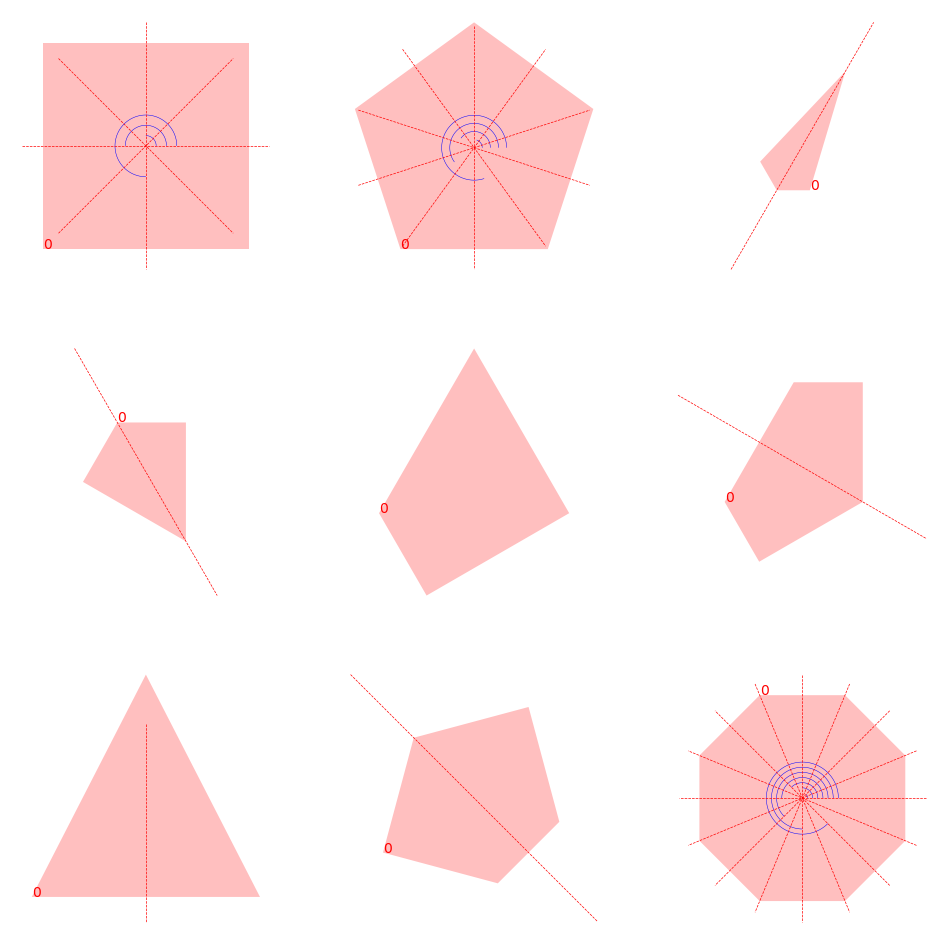

In [4]:
fig = pyplot.figure(figsize = (12, 12))

for poly, s, posn in zip(polys, symmetries, range(1, len(symmetries) + 1)):
  ax = fig.add_subplot(3, 3, posn)
  gpd.GeoSeries([poly]).plot(ax = ax, fc = "r", alpha = 0.25)

  if len(s.rotations) > 1: # null roation is always present but can't be drawn
    w = 200 / len(s.rotations)
    ls = []
    for i, r in enumerate(s.rotations):
      if i > 0:
        ls.append(
          geom.LineString(
            [[w * i * np.cos(a), w * i * np.sin(a)] 
              for a in np.linspace(0, np.pi / 180 * r, 100)]))
    gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)

  mirror_lines = s.reflection_axes
  if len(mirror_lines) > 0:
    gpd.GeoSeries(
      [affine.rotate(geom.LineString([(-600, 0), (600, 0)]), a) 
       for a in mirror_lines]).plot(
         ax = ax, color = "r", ls = "dashed", lw = 0.5)
  for i, p in enumerate(poly.exterior.coords):
    if i == 0:
      ax.annotate(text = i, xy = p, color = "r")
      
  pyplot.axis("off")

<Axes: >

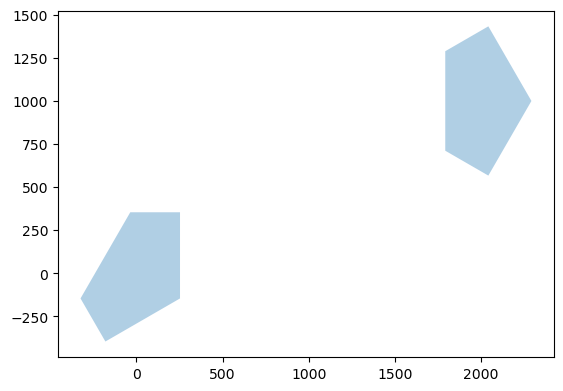

In [5]:
p = affine.translate(polys[5], 0, 0)
p2= affine.translate(affine.rotate(p, 30, "centroid"), 2000, 1000)
gpd.GeoSeries([p, p2]).plot(alpha = 0.35)

In [6]:
symmetries = Symmetries(p)
tr = symmetries.get_matching_transforms(p2)

In [7]:
tr

{'rotation-shifts': [0],
 'rotations': [0.0],
 'rotation-transforms': [[1.0, -0.0, 0.0, 1.0, 0, 0]],
 'reflection-shifts': [1],
 'reflections': [-29.999999948879598],
 'reflection-transforms': [(0.5000000015453693,
   -0.8660254028922193,
   -0.8660254028922193,
   -0.5000000015453693,
   0,
   0)],
 'pre-translation': [1, 0, 0, 1, -1999.9999999999998, -1000.0000000000001],
 'pre-rotation': [0.8660254040302613,
  0.4999999995742227,
  -0.4999999995742227,
  0.8660254040302613,
  0,
  0]}

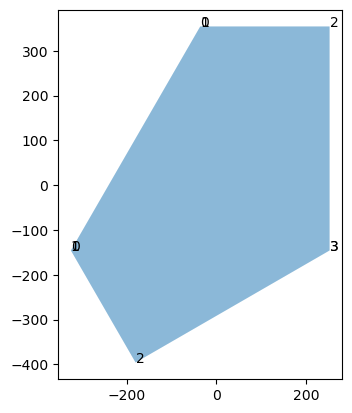

In [8]:
eg_transform = symmetries._combine_transforms(
  [
    tr["pre-translation"],
    tr["pre-rotation"],
    tr["reflection-transforms"][0]
  ]
)
p3 = affine.affine_transform(p2, eg_transform)
ax = gpd.GeoSeries([p, p3]).plot(alpha = 0.3)
for i, pt in enumerate(p.exterior.coords):
  if i < 4:
    ax.annotate(i, xy = pt)
for i, pt in enumerate(p3.exterior.coords):
  if i < 4:
    ax.annotate(i, xy = pt)

In [19]:
tr["reflection-shifts"]
list("EDCBAEDCB")[1:6]

['D', 'C', 'B', 'A', 'E']